# Identify SS using PARSIM-K


In [89]:
import matplotlib.pyplot as plt
import numpy as np

from sippy_unipi import SS_Model, system_identification
from sippy_unipi import functionset as fset
from sippy_unipi import functionsetSIM as fsetSIM
#from sippy_unipi._typing import SSMethods

import src.models as models
import src.helper as helper


## Creating a Dataset

In [90]:
A1 = 1
A2 = 0.5
k1 = 0.5
k2 = 0.8

TwoTanks = models.TwoTanks(True, A1, A2, k1, k2)

In [91]:
# example simulation
sim_time = 500
Ts = 1
h1 = 1
h2 = 0.5
h0 = [h1, h2]
u = np.ones((sim_time,2))*0.5


sim = TwoTanks.simulate(h0, u, Ts)

In [92]:
constrains = np.array([[0, 0.5], [0, 1]])
step_time = 100
no_steps = 100
steps = helper.generate_steps(step_time, no_steps, constrains)

In [93]:
Ts = 1
h1 = 1
h2 = 0.5
u1 = steps[0,:]
u2 = steps[1,:]

sim = TwoTanks.simulate([h1, h2], steps, Ts)

In [94]:
# add noise to sim data
add_noise = True
if add_noise:
    # add noise to the simulation data
    # set random seed for reproducibility
    np.random.seed(42)
    noise = np.random.normal(0, 0.1, sim["Y"].shape)
    sim["Y"] += noise

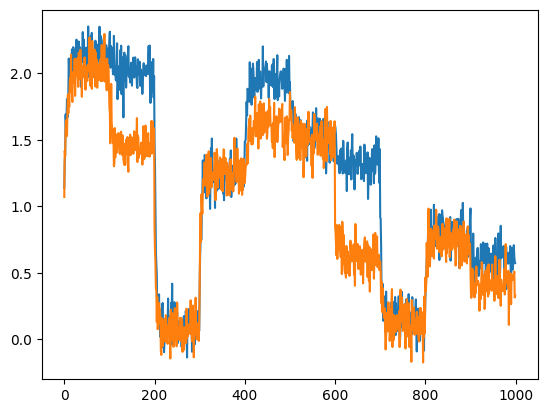

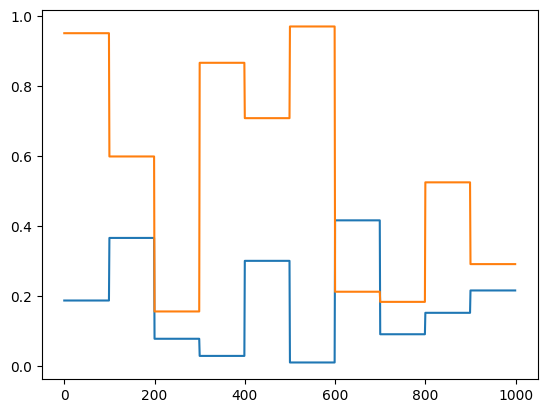

In [95]:
part = 1000
plt.plot(sim["Y"][:part])

plt.figure()
plt.plot(sim["U"][:part])

In [96]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load the scalers
scaler = joblib.load('data/scaler.pkl')
scalerU = joblib.load('data/scalerU.pkl')

# Scale the data
sim["Y"] = scaler.transform(sim["Y"])
sim["U"] = scalerU.transform(sim["U"])

In [97]:
train_sim = {key: value[:5000] for key, value in sim.items()}
test_sim = {key: value[7000:] for key, value in sim.items()}
dev_sim = {key: value[5000:7000] for key, value in sim.items()}

## Identification using PARSIM-K
```python

In [98]:
y_tot = train_sim["Y"]
U = train_sim["U"].T.copy()

In [99]:
sys_id = system_identification(y_tot.copy(), U.copy(), "PARSIM_K", 5, SS_threshold=0.00005)
if not isinstance(sys_id, SS_Model):
    raise ValueError("SS model not returned")
sys_id.A, sys_id.B, sys_id.C, sys_id.D

(array([[ 9.01810154e-01,  1.41056227e-01, -5.58816159e-02,
          1.02827698e-02, -3.53234628e-03],
        [ 1.01283238e-01,  8.44915482e-01,  5.56562615e-02,
         -2.34909294e-02,  2.45199500e-02],
        [-2.88143981e-02,  4.51102210e-02,  9.70488447e-01,
          1.79954750e-02,  2.59773491e-02],
        [-7.64039190e-02,  2.49428313e-04,  1.64037572e-02,
         -7.30212163e-01, -6.48975842e-01],
        [-4.57502207e-01,  8.75504974e-02, -1.15730478e-02,
          6.09775363e-01, -5.39505960e-01]]),
 array([[-0.03644266, -0.04874169],
        [ 0.04015752,  0.03868599],
        [-0.01130464, -0.03236079],
        [ 0.08422735,  0.3236589 ],
        [-0.17278891,  0.83418953]]),
 array([[-3.10112091,  1.28274978,  0.37353557,  0.11249466, -0.22067157],
        [-2.81345964,  0.03603327, -0.83128596, -0.00577199,  0.19170643]]),
 array([[0., 0.],
        [0., 0.]]))

In [100]:
append = "_parsimK"
np.save("data/A"+append+".npy", sys_id.A)
np.save("data/B"+append+".npy", sys_id.B)
np.save("data/C"+append+".npy", sys_id.C)

In [101]:
#Prediction on test dataset
xid, yid = fsetSIM.SS_lsim_process_form(
        sys_id.A, sys_id.B, sys_id.C, sys_id.D, test_sim["U"].T,np.linalg.pinv(sys_id.C)@test_sim["Y"][0].reshape(-1, 1)
    )

In [102]:
xid[:,0] = np.linalg.pinv(sys_id.C)@test_sim["Y"][0]
for i in range(yid.shape[1]-1):
    xid[:,i+1] = sys_id.A@ xid[:,i] + sys_id.B @ test_sim["U"].T[:,i]
    yid[:,i] = sys_id.C @ xid[:,i]

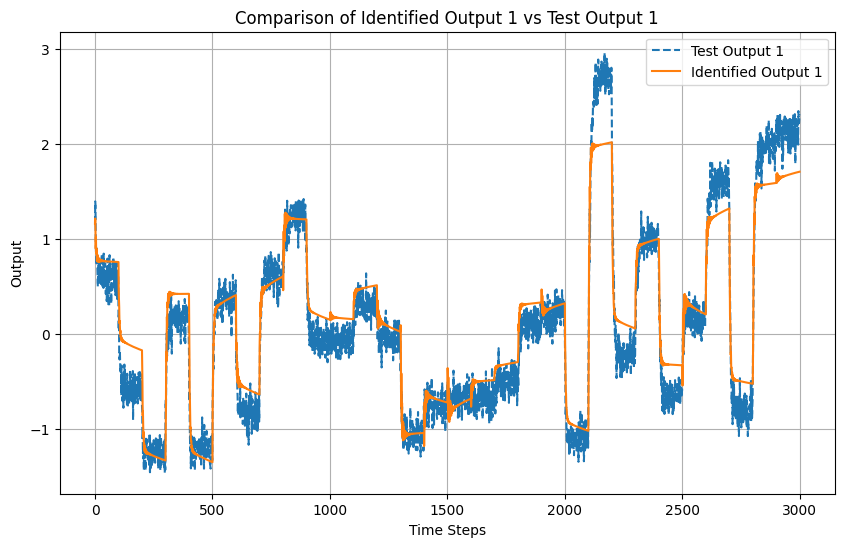

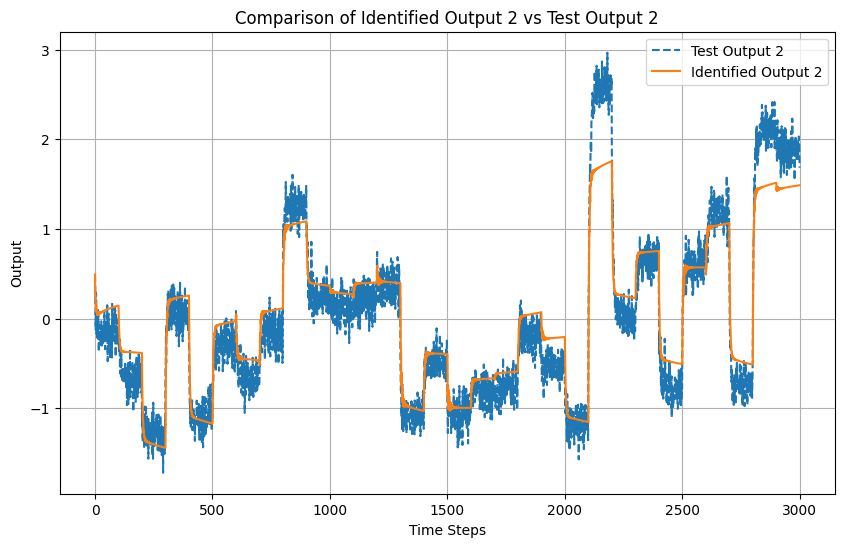

In [103]:
plt.figure(figsize=(10, 6))
plt.plot(test_sim["Y"][:, 0], label="Test Output 1", linestyle="--")
plt.plot(yid[0, :], label="Identified Output 1")
plt.xlabel("Time Steps")
plt.ylabel("Output")
plt.title("Comparison of Identified Output 1 vs Test Output 1")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(test_sim["Y"][:, 1], label="Test Output 2", linestyle="--")
plt.plot(yid[1, :], label="Identified Output 2")
plt.xlabel("Time Steps")
plt.ylabel("Output")
plt.title("Comparison of Identified Output 2 vs Test Output 2")
plt.legend()
plt.grid()
plt.show()

In [104]:
xid, yid = fsetSIM.SS_lsim_process_form(
        sys_id.A, sys_id.B, sys_id.C, sys_id.D, train_sim["U"].T, sys_id.x0#np.linalg.pinv(sys_id.C)@train_sim["Y"][0].reshape(-1, 1)#sys_id.x0
    )

In [105]:
xid[:,0] = np.linalg.pinv(sys_id.C)@train_sim["Y"][0]
for i in range(yid.shape[1]-1):
    xid[:,i+1] = sys_id.A@ xid[:,i] + sys_id.B @ train_sim["U"].T[:,i]
    yid[:,i] = sys_id.C @ xid[:,i]

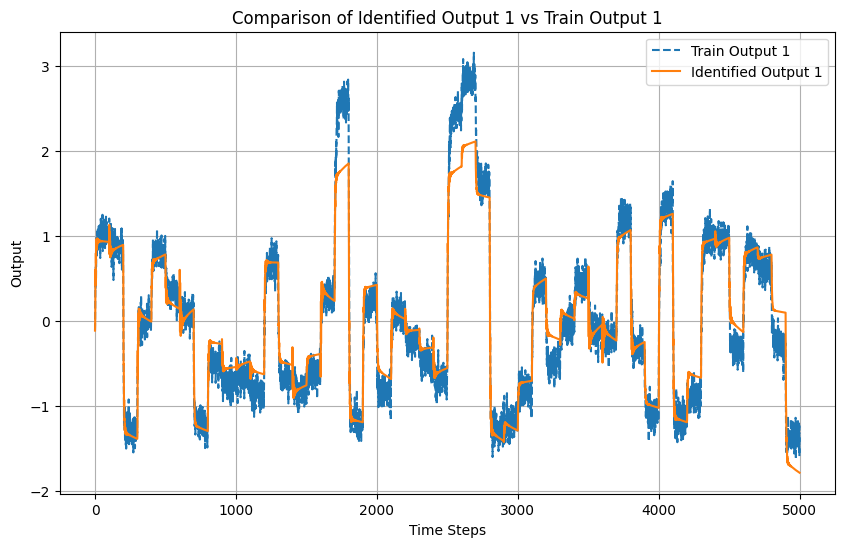

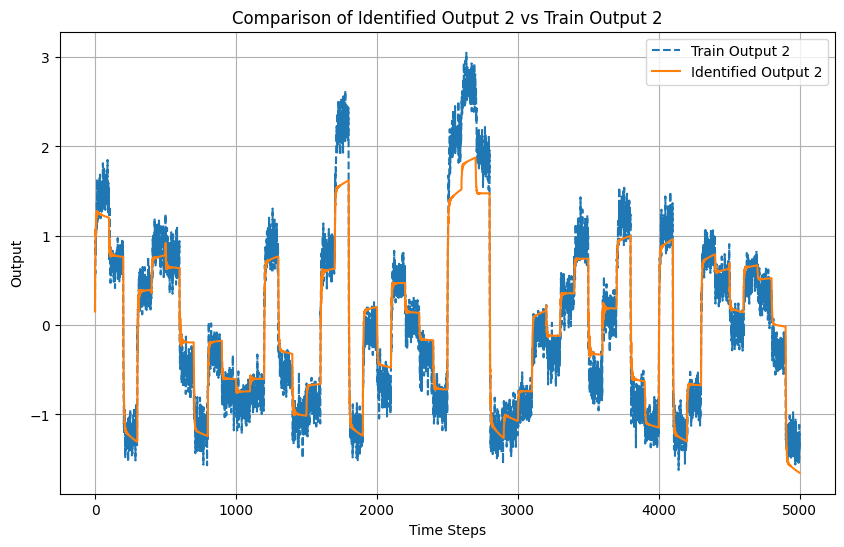

In [106]:
plt.figure(figsize=(10, 6))
plt.plot(train_sim["Y"][:, 0], label="Train Output 1", linestyle="--")
plt.plot(yid[0, :], label="Identified Output 1")
plt.xlabel("Time Steps")
plt.ylabel("Output")
plt.title("Comparison of Identified Output 1 vs Train Output 1")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_sim["Y"][:, 1], label="Train Output 2", linestyle="--")
plt.plot(yid[1, :], label="Identified Output 2")
plt.xlabel("Time Steps")
plt.ylabel("Output")
plt.title("Comparison of Identified Output 2 vs Train Output 2")
plt.legend()
plt.grid()
plt.show()

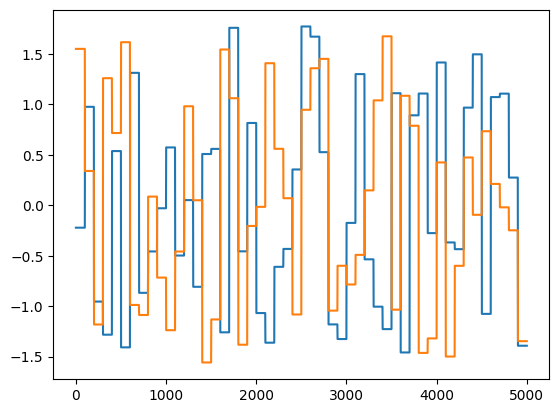

In [107]:
plt.plot(train_sim["U"])

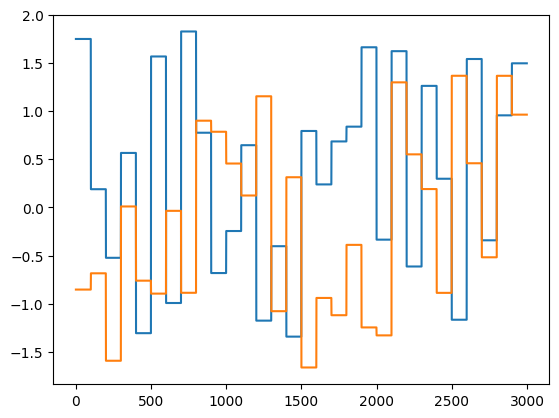

In [108]:
plt.plot(test_sim["U"])